# PPO and A2C

**Note** : this script is inspired from the 1st assignment (without correction) from the RL course of the MVA master by A. Lazaric and M. Pirotta, on finite MDP and function approximation, which required to complete a partial implementation of A2C for discrete action space. It has been extended to include a different critic and actor architecture, continuous action space, and the clipped and adaptative KL losses required for PPO.

In [1]:
import os
import numpy as np
from pathlib import Path
from pprint import pprint
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

try :
    import Box2D
except :
    !pip install Box2D
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
from torch.distributions import normal

import gym
from gym.wrappers import Monitor
from gym.spaces import Box, Discrete

# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
# from IPython.display import clear_output
# import base64



######################## Import internal modules 

# import utils

In [2]:
try :
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/My\ Drive/RL-PPO
except :
    print("Script running locally")

Script running locally


## Setup the environment
See https://github.com/openai/gym/wiki/Leaderboard for description of OpenAIGym environments

Discrete control settings : 
* "Taxi-v3" : episodic & discrete setting both for states and actions (S/N/E/W/Pickup/Dropoff)
* __"CartPole-v0" / "CartPole-v1" : discrete action and continuous state space__
* __"MountainCar-v0" : discrete action and continuous state space__

Continous control settings :
* __"MountainCarContinuous-v0" (both state and action continuous spaces)__
* "LunarLanderContinuous-v2" (requires box2D)
* "CarRacing-v0" : "Discrete control is reasonable in this environment as well" (requires box2D)

* "MsPacman-v0 "(requires the Atari dependency)

Settings used by the authors (requires the MuJoCo dependencies, 30 days free trial) : https://github.com/openai/mujoco-py
* "HalfCheetah-v1" (use v2 now?)
* "Hopper-v1"
* etc.

## Configuration 

See https://github.com/llSourcell/Unity_ML_Agents/blob/master/docs/best-practices-ppo.md for tuning best practice

In [3]:
def reset_config(print_=False):
    config = {}
#     config['env'] = 'CartPole-v1'
#     config['env'] = 'MountainCarContinuous-v0'
#     config['env'] = 'LunarLander-v2'
    config['env'] = 'MountainCar-v0'

    # config['std'] = 0.5 # use constant standard deviation for continuous action space (for now)
    config['std'] = 0.001 # use constant standard deviation for continuous action space (for now)
    config['gamma'] = 0.99 #Discount rate
    config['lambda'] = 1 # parameter of the generalized advantage estimation
    config['value_network'] = {'lr': 1e-3}
    config['actor_network'] = {'lr': 1e-3}
    config['eps_clipping'] = 0.2 #range : 0.1-0.3
    config['d_targ'] = 0.01
    config['beta_KL'] = 3
    config['c1'] = 1 #paramter of the value function loss
    config['c2'] = 1e-3 #entropy parameter --> 1e-4 to 1e-2
    config['epochs'] = 4
    config['max_episodes'] = 1000
    config['max_steps'] = 300
    config['optimize_every'] = 2000
    config['batch_size'] = 10 #512-5120 for continuous / 32-512 for discrete
    # config['buffer_size'] = 2048 #2048 - 409600 /!\ multiple of the batch size
    config['loss_name'] = ["A2C_loss","adaptative_KL_loss","clipped_loss"][2]
    config['color'] = {"A2C_loss":sns.color_palette("Set2")[0],"adaptative_KL_loss":sns.color_palette("Set2")[1],"clipped_loss":sns.color_palette("Set2")[2]}

    config['seed'] = 1
    config["reset_val"] = None # use to reset the environment with a custom value
    config["solved_reward"] = {'LunarLander-v2':230,
                              'MountainCarContinuous-v0':300,
                              'CartPole-v1':300,
                              'MountainCar-v0':300}
    
    if print_== True :
        print("Training config : \n", config)
    return config

In [4]:
## reset configuration
config = reset_config(print_=True)

Training config : 
 {'env': 'MountainCar-v0', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


In [5]:
## Define environment 
env = gym.make(config['env'])
print(config["env"])
## Save episode
# env = Monitor(env, "./gym-results", force=True)

## Action and state spaces
print("State Space : {}".format(env.observation_space))
if isinstance(env.observation_space, Box) :
    print("continuous state space") 
    print("Lower bound : ", env.observation_space.low)
    print("Upper bound : ", env.observation_space.high)
else :
    print("discrete state space")

print("\nAction Space : {}".format(env.action_space))
if isinstance(env.action_space, Box):
    print("continuous action space") 
    print("Lower bound : ", env.action_space.low)
    print("Uppder bound : ", env.action_space.high)
else :
    print("discrete action space")

print("\nReward range", env.reward_range)
    
## Reset the environment
obs = env.reset()
print("\nInitial state : ",obs)
env = env.env
# env.render()

## Sample randomly one action
action = env.action_space.sample()
print("Sampled action : " , action)

try :
    state, reward, done, info = env.step(a = action)
except :
    state, reward, done, info = env.step(action = action)
# env.render()
print("\nEpisode over : ",done)

MountainCar-v0
State Space : Box(2,)
continuous state space
Lower bound :  [-1.2  -0.07]
Upper bound :  [0.6  0.07]

Action Space : Discrete(3)
discrete action space

Reward range (-inf, inf)

Initial state :  [-0.40988285  0.        ]
Sampled action :  1

Episode over :  False


## Actor and critic networks 


**Note** : 
- these architectures were not defined precisely in the paper 
- no parameter sharing between policy and value function

In [6]:
class CustomValueNetwork(nn.Module):
    """
    Approximation of the value function V of a state given as input
    FC network with 1 hidden layer and ReLU activations
    Class used as 'critic'
    Inputs : 
    input_size : dimension of each state
    hidden_size : number of hidden layers
    output_size : 1 (dimension of the value function estimate)
    """

    def __init__(self, input_size, hidden_size, output_size = 1):
        super(CustomValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x.float()))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [0]:
# test 
critic = CustomValueNetwork(env.observation_space.shape[0], 16, 1)
critic(torch.tensor(env.state))

tensor([0.2635], grad_fn=<AddBackward0>)

In [7]:
class CustomDiscreteActorNetwork(nn.Module):
    """
    Custom policy model network for discrete action space
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers (64 in author's paper for continous action space)
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size):
        super(CustomDiscreteActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

In [8]:
class ContinuousActorNetwork(nn.Module):
    """
    Policy model network for continuous action space (from the paper)
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers used by the authors
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size, std, env):
        super(ContinuousActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.std = std
        self.env = env
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x.float()))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        return out
    
    def select_action(self, x):
        sampled_a = torch.normal(self(x), self.std).detach().numpy()
        sampled_a = max(self.env.action_space.low, sampled_a)
        sampled_a = min(self.env.action_space.high, sampled_a)
        return sampled_a

In [0]:
# test
if isinstance(env.action_space, Discrete) : #check if we are in a discrete action space
    actor = CustomDiscreteActorNetwork(env.observation_space.shape[0], 64, env.action_space.n)
else :
    actor = ContinuousActorNetwork(env.observation_space.shape[0], 64, env.action_space.shape[0], config["std"], env)

print("Mean : ", actor(torch.tensor(env.state)))
print("Sampled action : ", actor.select_action(torch.tensor(env.state)))

Mean :  tensor([0.5120, 0.4880], grad_fn=<SoftmaxBackward>)
Sampled action :  [0]


In [11]:
def plot_result(*df,config,var=["Episode","Reward"]):
    plt.figure(figsize=(8,4))
    for r in df :
        loss_name = r['loss_name'].unique()[0]
        sns.lineplot(x=var[0], y=var[1],  ci='sd', data=r, color=config["color"][loss_name],label=loss_name) 
def plot_sumup(rewards_list,loss_list,config=config):
    plot_result(*rewards_list,config=config)
    plot_result(*loss_list,config=config,var=["Update","entropy"])
    plot_result(*loss_list,config=config,var=["Update","dry_loss"])

def plot_sensitivity(*df,config,label_list,var=["Episode","Reward"]):
    plt.figure(figsize=(8,4))
    for i in range(len(label_list)):
        r=df[i]
        col = list(sns.color_palette("Set1")+sns.color_palette("Set3"))[i]
        sns.lineplot(x=var[0], y=var[1],  ci='sd', data=r, 
                     color=col,label=label_list[i])

In [62]:
class PPOAgent:

    def __init__(self, config):
        ## configuration
        self.config = config
        
        ## define environment
        self.env = gym.make(config['env'])
        self.discrete_action_bool = isinstance(self.env.action_space, Discrete) # boolean for discrete action space
        self.gamma = config['gamma'] #discount rate
        self.lambd = config['lambda'] #parameter of the generalized advantage estimation
        self.c1 = config['c1'] # value function hyperparameter
        self.c2 = config['c2'] # entropy bonus hyperparameter (eventually set to 0)
        self.loss_name = config['loss_name'] # loss in ["A2C_loss","adaptative_KL_loss","clipped_loss"]
        self.kl_div = nn.KLDivLoss(reduction="none") # KL divergence
        self.beta_kl = config['beta_KL'] # beta parameter for the KL divergence
        self.reset_val = config["reset_val"] # specify a value for env reset
        if self.discrete_action_bool == False :
            print("Low : ",self.env.action_space.low)
            print("High : ",self.env.action_space.high)
        
        ## set random seeds
        np.random.seed(config['seed'])
        torch.manual_seed(config['seed'])
        self.env.seed(config['seed'])
        
#         # save trajectory
#         self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        
        
        ## Define actor and critic networks and optimizers
        # Critic
        self.value_network = CustomValueNetwork(self.env.observation_space.shape[0], 16, 1)
        
        # self.value_network_optimizer: optim.Optimizer = optim.RMSprop(
        self.value_network_optimizer: optim.Optimizer = optim.Adam(
            self.value_network.parameters(), lr=config['value_network']['lr'])
        
        # Actor     
        if self.discrete_action_bool : #check if we are in a discrete action space
            self.actor_network = CustomDiscreteActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.n)
        else :
            self.actor_network = ContinuousActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.shape[0], self.config["std"], self.env)
        
        # self.actor_network_optimizer: optim.Optimizer = optim.RMSprop(
        self.actor_network_optimizer: optim.Optimizer = optim.Adam(
            self.actor_network.parameters(), lr=config['actor_network']['lr'])
        
        # save in memory policy estimates
        self.probs_list = [] #probability of actions taken
        self.mean_list = [] #mean estimate (for continuous action)
        
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        returns = 0*torch.tensor(rewards)
        values = torch.tensor(values)
        
        R = next_value
        for i in range(1, len(rewards)+1):
            retro_prop = 1-dones[-i]  # whether to use the following value
            R = rewards[-i] + (self.lambd*self.gamma * retro_prop * R)
            returns[-i] = R
        
        advantages = returns - values
        return returns, advantages

    def training(self, epochs, optimize_every, max_episodes, max_steps):
        t1 = datetime.datetime.now()
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        timestep_count = 0
        actions = []
        dones = []
        rewards, values = [], []
        returns, advantages = [], []
        observations = []    
        rewards_test = []
        loss_evol = {'loss':[],'dry_loss':[],'entropy':[]}
        if self.loss_name not in ["A2C_loss","adaptative_KL_loss","clipped_loss"]:
            print('Unknown loss function, using clipped loss as default loss')
        else :
            print('Loss : ',self.loss_name)
        
        for ep in range(max_episodes):
            episode_count +=1
#             assert self.break_bool == False
            obs = self.env.reset()
            ## added : special initialization
            if self.reset_val is not None:
                self.env.env.state = np.array(self.reset_val)
                obs = self.env.env.state
                
            
            for i in range(max_steps):
                timestep_count +=1 
                observations.append(obs)  # just observed s_t
                obs_t = torch.from_numpy(obs).float()  # tensor
                action = self.actor_network.select_action(obs_t)  # act on just observed, action a_t
                
                if self.discrete_action_bool : #convert to integer only for discrete action space
                    action = int(action)
                actions.append(action)
  
                # value function estimate of s_t
                values.append(self.value_network(obs_t))
                
                ## Run a step : get new state s_{t+1} and rewards r_t
                obs, reward, done, _ = self.env.step(action) 
                
                # Store termination status reward
                dones.append(done)
                rewards.append(reward)
                 
                if (timestep_count % optimize_every) == 0 :
                     # Learning step !
                    if done :
                        next_value = 0
                    else :
                        obs_t = torch.from_numpy(observations[-1]).float()
                        next_value = self.value_network.predict(obs_t)
                    # Compute returns and advantages
                    returns_, advantages_ = self._returns_advantages(rewards, dones, values, next_value)
                    returns.append(returns_)
                    advantages.append(advantages_)
                    
                    for epoch in range(epochs):
                        loss_val, dry_loss_val, entrop_val = self.optimize_model(observations, actions, returns, dones, advantages)
                        # only save result of last epoch #?? save more for fine tuning nb of epochs ??
                        if epoch == epochs-1 : 
                            loss_evol["loss"].append(loss_val)
                            loss_evol["dry_loss"].append(dry_loss_val)
                            loss_evol["entropy"].append(entrop_val)
                    # reset ??TOCHECK : reset less often ? 
                    actions = []
                    dones = []
                    rewards, values = [], []
                    returns, advantages = [], []
                    observations = []    
                
                # reset the environment if last observation is the a terminal state
                ##?? to remove?
                if done:
                    next_value = 0
                    # Compute returns and advantages
                    returns_, advantages_ = self._returns_advantages(rewards, dones, values, next_value)
                    returns.append(returns_)
                    advantages.append(advantages_)
                    break 
                
            # Test every 25 episodes
            if ep == 1 or (ep > 0 and ep % 25 == 0) or (ep == max_episodes - 1):
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Episode {ep}/{max_episodes}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

#        #?? Early stopping ++ to add --> which condition ?? certain avg reward ? 
            
                
        self.env.close()
        t2 = datetime.datetime.now()
        
        # save rewards
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Episode', 'Reward'])
        r["Episode"] = r["Episode"]*25
        r["loss_name"] = self.loss_name # add loss name as label
        
#         # Plot
#         sns.lineplot(x="Episode", y="Reward", data=r, ci='sd',color=config["color"][self.loss_name],label=self.loss_name)
        
        # Total time ellapsed
        time = t2-t1
        print(f'The training was done over a total of {episode_count} episodes')
        print('Total time ellapsed during training : ',time)
        r["time"]=time
        loss_evol = pd.DataFrame(loss_evol).astype(float)
        loss_evol["loss_name"] = self.loss_name
        loss_evol["Update"] = range(len(loss_evol))
        return r, loss_evol
        
        
    def A2C_loss(self, prob, actions, advantages):
        loss = 0.
        if self.discrete_action_bool :
            for i in range(len(actions)):
                loss -= torch.log(prob[i, int(actions[i])]+1e-6)*advantages[i]
        else :
            loss = torch.dot(torch.log(prob.view(-1)+1e-6),advantages)      
        return loss
    
    def compute_proba_ratio(self, prob, actions):
        if self.discrete_action_bool: 
             #1st iteration : initialize old policy to the current one to avoid clipping
            if len(self.probs_list) == 1:
                old_prob = self.probs_list[0]
            else :
                old_prob = self.probs_list[len(self.probs_list)-2]
        else :
            if len(self.mean_list) == 1:
                old_prob_mean = self.mean_list[0]
            else :
                old_prob_mean = self.mean_list[len(self.mean_list)-2]
            m = normal.Normal(loc = old_prob_mean.float(), scale = torch.tensor(config["std"]*np.ones(actions.size())).float())
            old_prob = m.log_prob(actions.float()).reshape(actions.size()).detach()
            
        # Discrete action space
        if self.discrete_action_bool :
            # compute the ratio directly using gather function
            num = prob.gather(1, actions.long().view(-1,1))
            denom = old_prob.detach().gather(1, actions.long().view(-1,1))
            ratio_vect = num.view(-1)/denom.view(-1)
        
        # Continuous action space
        else :## NB : add small constant to avoid ratio explosion 
            #?? replace "+1e-6" by clamp to min=1e-6?
            ratio_vect = prob/(old_prob+1e-6)
        
        if np.isnan(ratio_vect.detach().numpy()).any():
            print("NaN encountered in proba ratio")

        return ratio_vect, old_prob
    
    def clipped_loss(self, prob, actions, advantages):##++TODO
        ##Compute the probability ratio
        ratio_vect = self.compute_proba_ratio(prob, actions)[0]
        if len(actions.size())>1 :
            ratio_vect = torch.prod(ratio_vect, dim = 1)
        
        ## Compute the loss
        loss1 = ratio_vect * advantages
        loss2 = torch.clamp(ratio_vect, 1-self.config['eps_clipping'], 1+self.config['eps_clipping']) * advantages
        loss = - torch.sum(torch.min(loss1, loss2))/self.config["batch_size"]
        return loss

    def adaptative_KL_loss(self, prob, actions, advantages, observations):
        ## Compute the loss
        if self.discrete_action_bool :
            ##Compute the probability ratio
            ratio_vect, old_prob = self.compute_proba_ratio(prob, actions)
            kl = self.kl_div(prob[observations.long(),:], old_prob[observations.long(),:])
            kl = kl.view(prob.size()[0],-1).mean(1)
        else :
            ratio_vect = self.compute_proba_ratio(prob, actions)[0]
            if len(self.mean_list) == 1:
                kl = torch.tensor(0.)
            else :
                mu = prob.view(-1)
                mu_old = self.mean_list[len(self.mean_list)-2].view(-1).detach()
                # use KL formula for gaussian 
                kl = torch.dot((mu-mu_old)/torch.tensor(config["std"]*np.ones(len(actions))).float(),mu-mu_old)/2
                
        loss = - torch.sum((ratio_vect*advantages) - (self.beta_kl*kl))/self.config["batch_size"]
        # Update beta values
        if np.isnan(torch.mean(kl).detach().numpy()):
            print("Nan encountered in average KL divergence")
        if torch.mean(kl) < self.config["d_targ"]/1.5 : 
            self.beta_kl = self.beta_kl / 2
        elif torch.mean(kl) > self.config["d_targ"]*1.5 :
            self.beta_kl = self.beta_kl * 2
        return loss
    
    
        
    def optimize_model(self, observations, actions, returns, dones, advantages):
        
        n_trajs = np.sum(dones)
        observations = torch.tensor(observations).float()
        actions = torch.tensor(actions).float()
        returns = returns[len(returns)-1].float()
        advantages = advantages[len(advantages)-1].float()
    
        # Critic loss
        net_values: torch.Tensor = self.value_network(observations)
        critic_loss = F.mse_loss(net_values.view(-1), returns)
        critic_loss.backward()
        
        self.value_network_optimizer.step()
        
        # Actor & Entropy loss
        #/!\ doesn't have the same meaning in the discrete and continuous case
        prob: torch.Tensor = self.actor_network(observations)  # shape (batch_size,action_space)
        
        
        if self.discrete_action_bool == True :
            self.probs_list.append(prob.detach())
        else : #/!\ continuous actions may have several dimensions
            m = normal.Normal(loc = prob.float(), scale = torch.tensor(config["std"]*np.ones(actions.size())).float())
            logprob = m.log_prob(actions.float()).reshape(actions.size())
            self.probs_list.append(torch.exp(logprob).detach()) #not very useful 
            # append the gaussian mean (used to estimate old proability)
            self.mean_list.append(prob)
        
        if not dones[-1]:
            n_trajs += 1
        
        if self.loss_name == "clipped_loss":
            loss = self.clipped_loss(prob, actions, advantages)

        elif self.loss_name == "adaptative_KL_loss":
            loss = self.adaptative_KL_loss(prob, actions, advantages, observations)
            
        elif self.loss_name == "A2C_loss":
            loss = self.A2C_loss(prob, actions, advantages)
            
        else :#use clipped loss as default
            loss = self.clipped_loss(prob, actions, advantages)
            
        dry_loss = loss 
        entropy_term = -torch.sum(prob * torch.log(prob+1e-6))
        loss -= (self.c2 * entropy_term)
        loss = loss / n_trajs
        
        loss.backward()
        
        self.actor_network_optimizer.step()
        
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()

        return loss.detach().numpy(), dry_loss.detach().numpy(), entropy_term.detach().numpy()

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        ## added : special initialization
        if self.reset_val is not None:
            self.env.env.state = np.array(self.reset_val)
            observation = self.env.env.state
        observation = torch.from_numpy(observation).float()
        reward_episode = 0
        done = False
        with torch.no_grad():
            while not done:
                policy = self.actor_network(observation)
                
                if self.discrete_action_bool : 
                    action = int(torch.multinomial(policy, 1))  # draw an action ##??why not only sample action ?? (coming from Lazaric)
                else :
                    action = self.actor_network.select_action(observation)
                observation, reward, done, info = env.step(action)
                observation = torch.from_numpy(observation).float()
                reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

In [ ]:
##TORUN

reset_config()
config["env"] = 'MountainCarContinuous-v0'
config["epochs"] = 4
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

In [ ]:
##TORUN

reset_config()
config["env"] = 'MountainCarContinuous-v0'
config["epochs"] = 100
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

##### 4 epochs

/!\ The following cell corresponds to $\epsilon$ = 0.1 (low) and $\beta$ = 100 (very high)

In [64]:
# config["env"] = 'LunarLanderContinuous-v2'
config["env"] = 'MountainCarContinuous-v0'
# config["env"] = "Pendulum-v0"
# config["env"] = 'BipedalWalker-v3'
config["epochs"] = 4
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
{'env': 'MountainCarContinuous-v0', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Low :  [-1.]
High :  [1.]
Loss :  clipped_loss
Episode 1/1000: Mean rewards: -2.0, Std: 0.0
Episode 25/1000: Mean rewards: -13.6, Std: 0.01
Episode 50/1000: Mean rewards: -6.53, Std: 0.0
Episode 75/1000: Mean rewards: -12.9, Std: 0.

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


Episode 25/1000: Mean rewards: -99.9, Std: 0.0
Episode 50/1000: Mean rewards: -99.9, Std: 0.0
Episode 75/1000: Mean rewards: -99.9, Std: 0.0
Episode 100/1000: Mean rewards: -99.9, Std: 0.0
Episode 125/1000: Mean rewards: -99.9, Std: 0.0
Episode 150/1000: Mean rewards: -99.9, Std: 0.0
Episode 175/1000: Mean rewards: -99.9, Std: 0.0
Episode 200/1000: Mean rewards: -99.9, Std: 0.0
Episode 225/1000: Mean rewards: -99.9, Std: 0.0
Episode 250/1000: Mean rewards: -99.9, Std: 0.0
Episode 275/1000: Mean rewards: -99.9, Std: 0.0
Episode 300/1000: Mean rewards: -99.9, Std: 0.0
Episode 325/1000: Mean rewards: -99.9, Std: 0.0
Episode 350/1000: Mean rewards: -99.9, Std: 0.0
Episode 375/1000: Mean rewards: -99.9, Std: 0.0
Episode 400/1000: Mean rewards: -99.9, Std: 0.0
Episode 425/1000: Mean rewards: -99.9, Std: 0.0
Episode 450/1000: Mean rewards: -99.9, Std: 0.0
Episode 475/1000: Mean rewards: -99.9, Std: 0.0
Episode 500/1000: Mean rewards: -99.9, Std: 0.0
Episode 525/1000: Mean rewards: -99.9, Std:

Pickle name :  46265381
Configuration :  {'env': 'MountainCarContinuous-v0', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'A2C_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


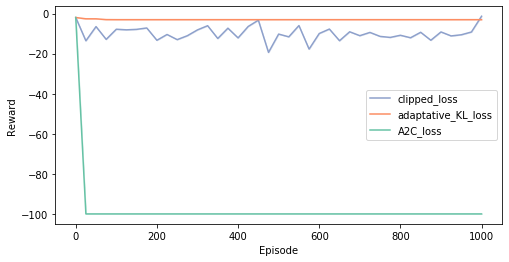

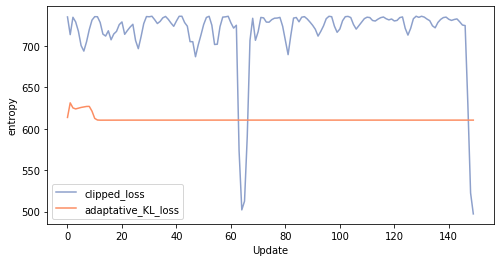

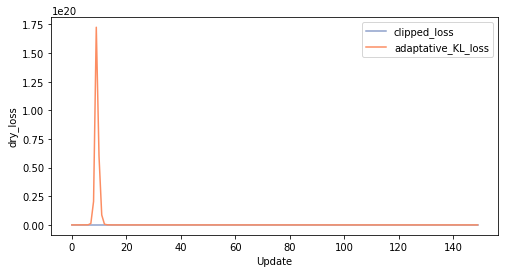

In [65]:
plot_sumup(rewards_list,loss_list,config=config)
name = str(np.random.randint(0,1e8))
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

##### 100 epochs

/!\ The following cell corresponds to $\epsilon$ = 0.1 (low) and $\beta$ = 100 (very high)

In [66]:
# config["env"] = 'LunarLanderContinuous-v2'
config["env"] = 'MountainCarContinuous-v0'
# config["env"] = "Pendulum-v0"
# config["env"] = 'BipedalWalker-v3'
config["epochs"] = 100
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
{'env': 'MountainCarContinuous-v0', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 100, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Low :  [-1.]
High :  [1.]
Loss :  clipped_loss


C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 1/1000: Mean rewards: -2.0, Std: 0.0
Episode 25/1000: Mean rewards: -13.39, Std: 0.02
Episode 50/1000: Mean rewards: -13.24, Std: 0.01
Episode 75/1000: Mean rewards: -8.19, Std: 0.0
Episode 100/1000: Mean rewards: -1.69, Std: 0.0
Episode 125/1000: Mean rewards: -13.45, Std: 0.01
Episode 150/1000: Mean rewards: -12.61, Std: 0.01
Episode 175/1000: Mean rewards: -13.3, Std: 0.01
Episode 200/1000: Mean rewards: -11.11, Std: 0.01
Episode 225/1000: Mean rewards: -13.28, Std: 0.01
Episode 250/1000: Mean rewards: -8.66, Std: 0.01
Episode 275/1000: Mean rewards: -9.31, Std: 0.01
Episode 300/1000: Mean rewards: -5.12, Std: 0.0
Episode 325/1000: Mean rewards: -13.41, Std: 0.01
Episode 350/1000: Mean rewards: -13.41, Std: 0.01
Episode 375/1000: Mean rewards: -13.45, Std: 0.01
Episode 400/1000: Mean rewards: -10.93, Std: 0.01
Episode 425/1000: Mean rewards: -11.46, Std: 0.01
Episode 450/1000: Mean rewards: -13.49, Std: 0.01
Episode 475/1000: Mean rewards: -13.76, Std: 0.01
Episode 500/1000:

C:\Users\Philo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


Episode 25/1000: Mean rewards: -99.9, Std: 0.0
Episode 50/1000: Mean rewards: -99.9, Std: 0.0
Episode 75/1000: Mean rewards: -99.9, Std: 0.0
Episode 100/1000: Mean rewards: -99.9, Std: 0.0
Episode 125/1000: Mean rewards: -99.9, Std: 0.0
Episode 150/1000: Mean rewards: -99.9, Std: 0.0
Episode 175/1000: Mean rewards: -99.9, Std: 0.0
Episode 200/1000: Mean rewards: -99.9, Std: 0.0
Episode 225/1000: Mean rewards: -99.9, Std: 0.0
Episode 250/1000: Mean rewards: -99.9, Std: 0.0
Episode 275/1000: Mean rewards: -99.9, Std: 0.0
Episode 300/1000: Mean rewards: -99.9, Std: 0.0
Episode 325/1000: Mean rewards: -99.9, Std: 0.0
Episode 350/1000: Mean rewards: -99.9, Std: 0.0
Episode 375/1000: Mean rewards: -99.9, Std: 0.0
Episode 400/1000: Mean rewards: -99.9, Std: 0.0
Episode 425/1000: Mean rewards: -99.9, Std: 0.0
Episode 450/1000: Mean rewards: -99.9, Std: 0.0
Episode 475/1000: Mean rewards: -99.9, Std: 0.0
Episode 500/1000: Mean rewards: -99.9, Std: 0.0
Episode 525/1000: Mean rewards: -99.9, Std:

Pickle name :  46265381
Configuration :  {'env': 'MountainCarContinuous-v0', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 100, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'A2C_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


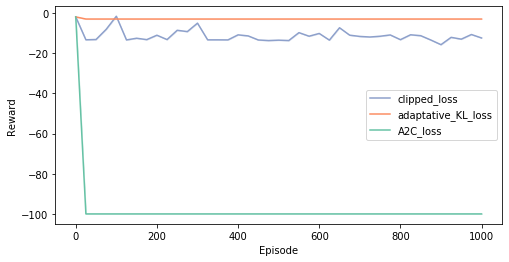

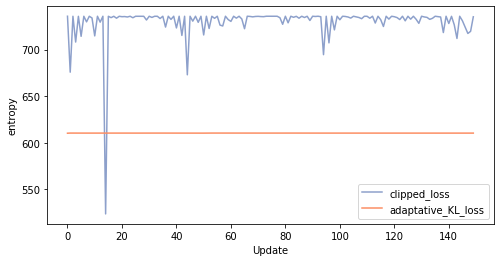

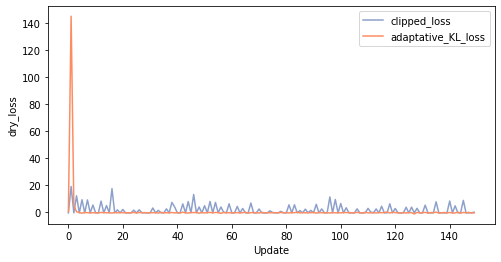

In [67]:
plot_sumup(rewards_list,loss_list,config=config)
name = str(np.random.randint(0,1e8))
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

## Discrete env

**Note** : oscillations

In [34]:
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std: 8.04
Episode 100/1000: Mean rewards: 24.7

Episode 800/1000: Mean rewards: 483.66, Std: 67.45
Episode 825/1000: Mean rewards: 456.92, Std: 109.53
Episode 850/1000: Mean rewards: 472.06, Std: 72.32
Episode 875/1000: Mean rewards: 474.2, Std: 74.26
Episode 900/1000: Mean rewards: 459.68, Std: 46.23
Episode 925/1000: Mean rewards: 463.98, Std: 50.05
Episode 950/1000: Mean rewards: 463.78, Std: 37.08
Episode 975/1000: Mean rewards: 494.14, Std: 13.86
Episode 999/1000: Mean rewards: 499.48, Std: 3.12
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:08:44.548898


Pickle name :  46265381
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'A2C_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


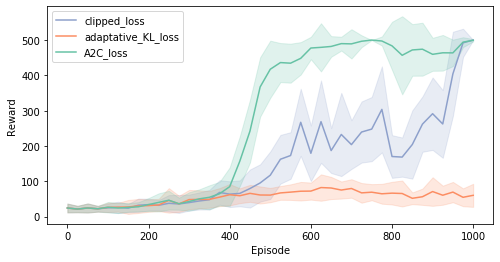

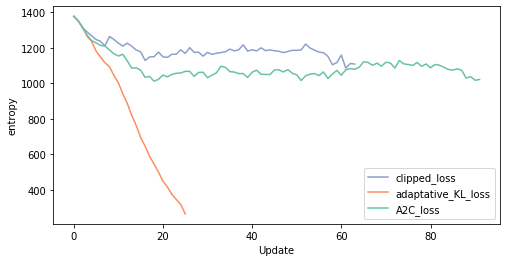

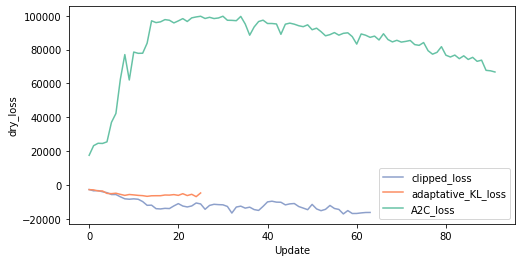

In [35]:
plot_sumup(rewards_list,loss_list,config=config)
name = str(np.random.randint(0,1e8))
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

### Clipped PPO - Sensitivity to $\epsilon$

In [36]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 1000
config["loss_name"]="clipped_loss"
print("-----------------"+config["loss_name"]+"-----------------")
eps_list = [0.1,0.15,0.2,0.25,0.3,0.5,0.8]
for eps in eps_list:
    print("--------eps=",eps)
    config['eps_clipping'] = eps
    print(config)
    agent = PPOAgent(config)
    config["batch_size"] = 100
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
--------eps= 0.1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std: 8.04
Episode 100/1000: M

Episode 875/1000: Mean rewards: 12.7, Std: 1.64
Episode 900/1000: Mean rewards: 13.54, Std: 2.0
Episode 925/1000: Mean rewards: 13.34, Std: 1.9
Episode 950/1000: Mean rewards: 14.32, Std: 2.08
Episode 975/1000: Mean rewards: 13.46, Std: 2.35
Episode 999/1000: Mean rewards: 13.34, Std: 2.39
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:04:33.826994
--------eps= 0.25
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.25, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 1000, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val':

Episode 700/1000: Mean rewards: 9.42, Std: 0.6
Episode 725/1000: Mean rewards: 9.34, Std: 0.82
Episode 750/1000: Mean rewards: 9.52, Std: 0.78
Episode 775/1000: Mean rewards: 9.42, Std: 0.75
Episode 800/1000: Mean rewards: 9.24, Std: 0.68
Episode 825/1000: Mean rewards: 9.4, Std: 0.77
Episode 850/1000: Mean rewards: 9.26, Std: 0.66
Episode 875/1000: Mean rewards: 9.22, Std: 0.73
Episode 900/1000: Mean rewards: 9.54, Std: 0.7
Episode 925/1000: Mean rewards: 9.38, Std: 0.72
Episode 950/1000: Mean rewards: 9.5, Std: 0.73
Episode 975/1000: Mean rewards: 9.24, Std: 0.79
Episode 999/1000: Mean rewards: 9.16, Std: 0.76
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:07:10.391344
--------eps= 0.8
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 1000, 'max_episodes': 1000, 'max_steps': 300,

Sensitivity list :  [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.8]
Pickle name :  1589134880
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 1000, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


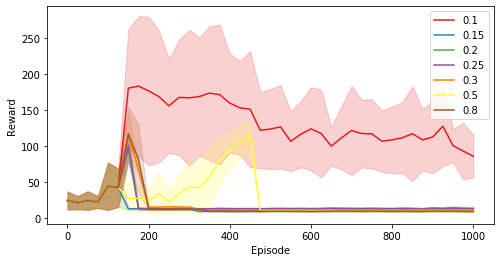

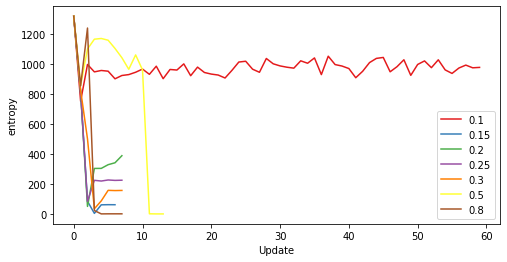

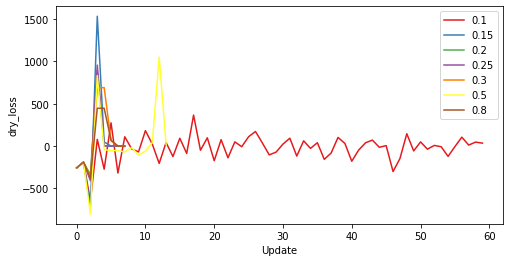

In [41]:
plot_sensitivity(*rewards_list,config=config,label_list=eps_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",eps_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))

In [54]:
# reset_config()
# config["env"] = 'CartPole-v1'
# rewards_list = []
# loss_list = []
# config["epochs"] = 100
# config["loss_name"]="clipped_loss"
# print("-----------------"+config["loss_name"]+"-----------------")
# eps_list = [0.1,0.15,0.2,0.25,0.3,0.5,0.8]
# for eps in eps_list:
#     print("--------eps=",eps)
#     config['eps_clipping'] = eps
#     print(config)
#     agent = PPOAgent(config)
#     config["batch_size"] = 100
#     rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
#     rewards_list.append(rewards)
#     loss_list.append(loss)

In [ ]:
# plot_sensitivity(*rewards_list,config=config,label_list=eps_list,var=["Episode","Reward"])
# plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Update","entropy"])
# plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Update","dry_loss"])

# name = str(int(datetime.datetime.now().timestamp()))
# print("Sensitivity list : ",eps_list)
# print("Pickle name : ",name)
# print("Configuration : ",config)
# pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))

In [44]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["loss_name"]="clipped_loss"
config["epochs"] = 4
print("-----------------"+config["loss_name"]+"-----------------")
eps_list = [0.1,0.15,0.2,0.25,0.3,0.5,0.8]
for eps in eps_list:
    print("--------eps=",eps)
    config['eps_clipping'] = eps
    print(config)
    agent = PPOAgent(config)
    config["batch_size"] = 100
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
--------eps= 0.1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std: 8.04
Episode 100/1000

Episode 800/1000: Mean rewards: 256.2, Std: 66.95
Episode 825/1000: Mean rewards: 229.86, Std: 48.22
Episode 850/1000: Mean rewards: 353.36, Std: 130.14
Episode 875/1000: Mean rewards: 305.4, Std: 159.34
Episode 900/1000: Mean rewards: 262.32, Std: 94.92
Episode 925/1000: Mean rewards: 339.18, Std: 132.11
Episode 950/1000: Mean rewards: 261.96, Std: 95.76
Episode 975/1000: Mean rewards: 211.92, Std: 63.14
Episode 999/1000: Mean rewards: 260.5, Std: 49.47
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:03:31.189480
--------eps= 0.25
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.25, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_los

Episode 550/1000: Mean rewards: 206.14, Std: 71.52
Episode 575/1000: Mean rewards: 197.36, Std: 81.55
Episode 600/1000: Mean rewards: 304.04, Std: 86.78
Episode 625/1000: Mean rewards: 159.06, Std: 17.37
Episode 650/1000: Mean rewards: 140.46, Std: 18.3
Episode 675/1000: Mean rewards: 151.26, Std: 14.86
Episode 700/1000: Mean rewards: 154.1, Std: 16.28
Episode 725/1000: Mean rewards: 170.92, Std: 18.9
Episode 750/1000: Mean rewards: 167.12, Std: 16.01
Episode 775/1000: Mean rewards: 162.76, Std: 16.87
Episode 800/1000: Mean rewards: 169.28, Std: 16.5
Episode 825/1000: Mean rewards: 186.24, Std: 22.25
Episode 850/1000: Mean rewards: 176.42, Std: 20.38
Episode 875/1000: Mean rewards: 175.74, Std: 18.27
Episode 900/1000: Mean rewards: 172.22, Std: 18.66
Episode 925/1000: Mean rewards: 159.8, Std: 15.88
Episode 950/1000: Mean rewards: 178.32, Std: 18.94
Episode 975/1000: Mean rewards: 194.48, Std: 19.02
Episode 999/1000: Mean rewards: 222.22, Std: 22.83
The training was done over a total o

Sensitivity list :  [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.8]
Pickle name :  1589145642
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


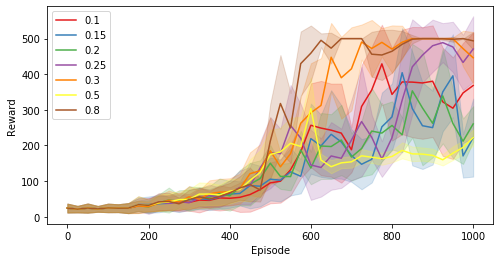

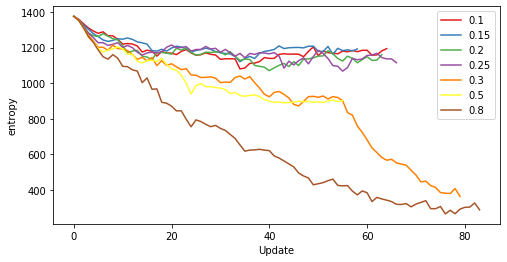

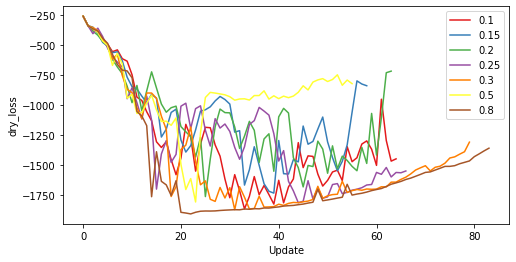

In [45]:
plot_sensitivity(*rewards_list,config=config,label_list=eps_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",eps_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))

### Adaptative KL - sensitivity to $\beta$ parameter

In [42]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 1000
config["loss_name"]="adaptative_KL_loss"
print("-----------------"+config["loss_name"]+"-----------------")
beta_list = [1e-1,1,2,2.5,3,3.5,4,5,10,100]
for beta in beta_list:
    config['beta_KL'] = beta
    print('------------beta=',beta)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------adaptative_KL_loss-----------------
------------beta= 0.1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 0.1, 'c1': 1, 'c2': 0.001, 'epochs': 1000, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  adaptative_KL_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, 

Episode 800/1000: Mean rewards: 14.8, Std: 1.99
Episode 825/1000: Mean rewards: 14.42, Std: 2.23
Episode 850/1000: Mean rewards: 14.88, Std: 1.97
Episode 875/1000: Mean rewards: 15.04, Std: 2.21
Episode 900/1000: Mean rewards: 14.44, Std: 2.18
Episode 925/1000: Mean rewards: 14.76, Std: 1.88
Episode 950/1000: Mean rewards: 13.82, Std: 2.11
Episode 975/1000: Mean rewards: 14.9, Std: 2.34
Episode 999/1000: Mean rewards: 15.16, Std: 2.33
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:06:20.404876
------------beta= 2.5
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 2.5, 'c1': 1, 'c2': 0.001, 'epochs': 1000, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9

Episode 600/1000: Mean rewards: 32.78, Std: 3.22
Episode 625/1000: Mean rewards: 31.96, Std: 3.27
Episode 650/1000: Mean rewards: 18.16, Std: 1.82
Episode 675/1000: Mean rewards: 18.2, Std: 1.62
Episode 700/1000: Mean rewards: 18.58, Std: 1.69
Episode 725/1000: Mean rewards: 18.62, Std: 1.87
Episode 750/1000: Mean rewards: 18.32, Std: 2.0
Episode 775/1000: Mean rewards: 18.46, Std: 2.0
Episode 800/1000: Mean rewards: 19.02, Std: 2.02
Episode 825/1000: Mean rewards: 18.4, Std: 2.34
Episode 850/1000: Mean rewards: 20.48, Std: 2.31
Episode 875/1000: Mean rewards: 20.72, Std: 2.47
Episode 900/1000: Mean rewards: 19.78, Std: 2.27
Episode 925/1000: Mean rewards: 19.98, Std: 2.37
Episode 950/1000: Mean rewards: 12.98, Std: 1.56
Episode 975/1000: Mean rewards: 13.38, Std: 1.72
Episode 999/1000: Mean rewards: 13.74, Std: 1.48
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:10:08.071475
------------beta= 4
{'env': 'CartPole-v1', 'std': 0.001, 'gamma':

Episode 400/1000: Mean rewards: 17.34, Std: 2.0
Episode 425/1000: Mean rewards: 17.56, Std: 1.89
Episode 450/1000: Mean rewards: 17.26, Std: 1.95
Episode 475/1000: Mean rewards: 17.6, Std: 1.96
Episode 500/1000: Mean rewards: 14.88, Std: 1.52
Episode 525/1000: Mean rewards: 14.6, Std: 1.52
Episode 550/1000: Mean rewards: 14.88, Std: 1.58
Episode 575/1000: Mean rewards: 14.68, Std: 1.7
Episode 600/1000: Mean rewards: 15.22, Std: 1.79
Episode 625/1000: Mean rewards: 14.88, Std: 1.61
Episode 650/1000: Mean rewards: 14.58, Std: 1.46
Episode 675/1000: Mean rewards: 14.48, Std: 1.36
Episode 700/1000: Mean rewards: 14.78, Std: 1.39
Episode 725/1000: Mean rewards: 14.78, Std: 1.58
Episode 750/1000: Mean rewards: 14.66, Std: 1.63
Episode 775/1000: Mean rewards: 14.92, Std: 1.6
Episode 800/1000: Mean rewards: 15.08, Std: 1.61
Episode 825/1000: Mean rewards: 14.78, Std: 1.6
Episode 850/1000: Mean rewards: 15.0, Std: 1.37
Episode 875/1000: Mean rewards: 15.1, Std: 1.63
Episode 900/1000: Mean rewar

Sensitivity list :  [0.1, 1, 2, 2.5, 3, 3.5, 4, 5, 10, 100]
Pickle name :  1589143341
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 1000, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


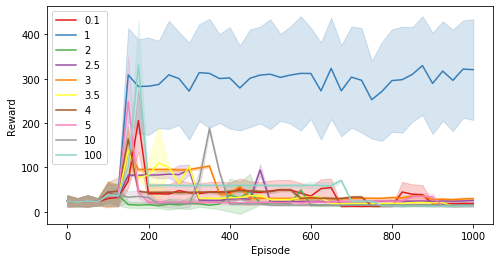

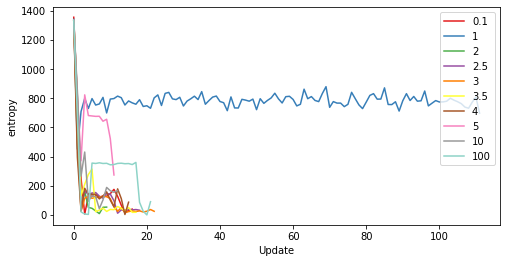

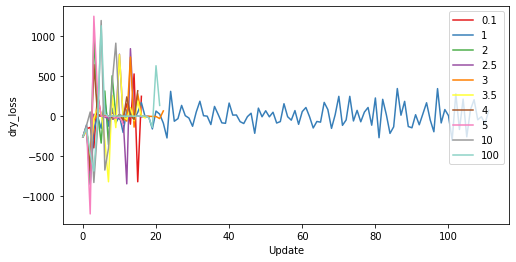

In [43]:
plot_sensitivity(*rewards_list,config=config,label_list=beta_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",beta_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

In [48]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 50
config["loss_name"]="adaptative_KL_loss"
print("-----------------"+config["loss_name"]+"-----------------")
beta_list = [1e-1,1,2,2.5,3,3.5,4,5,10,100]
for beta in beta_list:
    config['beta_KL'] = beta
    print('------------beta=',beta)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------adaptative_KL_loss-----------------
------------beta= 0.1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 0.1, 'c1': 1, 'c2': 0.001, 'epochs': 50, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  adaptative_KL_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, St

Episode 875/1000: Mean rewards: 9.62, Std: 0.8
Episode 900/1000: Mean rewards: 9.22, Std: 0.73
Episode 925/1000: Mean rewards: 9.36, Std: 0.69
Episode 950/1000: Mean rewards: 9.1, Std: 0.81
Episode 975/1000: Mean rewards: 9.34, Std: 0.95
Episode 999/1000: Mean rewards: 9.42, Std: 0.85
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:55.142560
------------beta= 2.5
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 2.5, 'c1': 1, 'c2': 0.001, 'epochs': 50, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_v

Episode 700/1000: Mean rewards: 500.0, Std: 0.0
Episode 725/1000: Mean rewards: 500.0, Std: 0.0
Episode 750/1000: Mean rewards: 500.0, Std: 0.0
Episode 775/1000: Mean rewards: 500.0, Std: 0.0
Episode 800/1000: Mean rewards: 500.0, Std: 0.0
Episode 825/1000: Mean rewards: 500.0, Std: 0.0
Episode 850/1000: Mean rewards: 500.0, Std: 0.0
Episode 875/1000: Mean rewards: 500.0, Std: 0.0
Episode 900/1000: Mean rewards: 500.0, Std: 0.0
Episode 925/1000: Mean rewards: 500.0, Std: 0.0
Episode 950/1000: Mean rewards: 500.0, Std: 0.0
Episode 975/1000: Mean rewards: 500.0, Std: 0.0
Episode 999/1000: Mean rewards: 500.0, Std: 0.0
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:14:05.775780
------------beta= 4
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 4, 'c1': 1, 'c2': 0.001, 'epochs': 50, 'max_episodes': 1000, 'max_steps':

Episode 525/1000: Mean rewards: 11.16, Std: 1.35
Episode 550/1000: Mean rewards: 11.32, Std: 1.41
Episode 575/1000: Mean rewards: 11.06, Std: 1.42
Episode 600/1000: Mean rewards: 11.56, Std: 1.54
Episode 625/1000: Mean rewards: 11.22, Std: 1.68
Episode 650/1000: Mean rewards: 11.0, Std: 1.52
Episode 675/1000: Mean rewards: 10.94, Std: 1.22
Episode 700/1000: Mean rewards: 10.88, Std: 1.16
Episode 725/1000: Mean rewards: 11.12, Std: 1.23
Episode 750/1000: Mean rewards: 10.84, Std: 1.29
Episode 775/1000: Mean rewards: 11.0, Std: 1.48
Episode 800/1000: Mean rewards: 10.92, Std: 1.2
Episode 825/1000: Mean rewards: 10.84, Std: 1.38
Episode 850/1000: Mean rewards: 11.0, Std: 1.37
Episode 875/1000: Mean rewards: 10.92, Std: 1.21
Episode 900/1000: Mean rewards: 10.46, Std: 1.1
Episode 925/1000: Mean rewards: 10.58, Std: 1.12
Episode 950/1000: Mean rewards: 10.36, Std: 1.26
Episode 975/1000: Mean rewards: 10.64, Std: 1.26
Episode 999/1000: Mean rewards: 10.72, Std: 1.37
The training was done ove

Sensitivity list :  [0.1, 1, 2, 2.5, 3, 3.5, 4, 5, 10, 100]
Pickle name :  1589149557
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 50, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


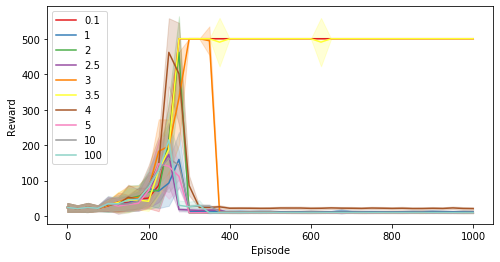

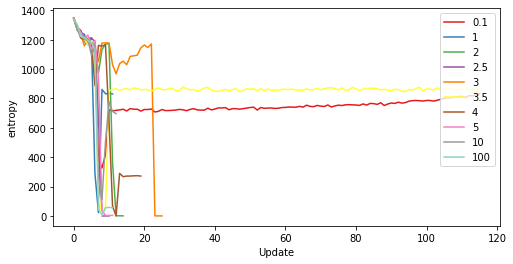

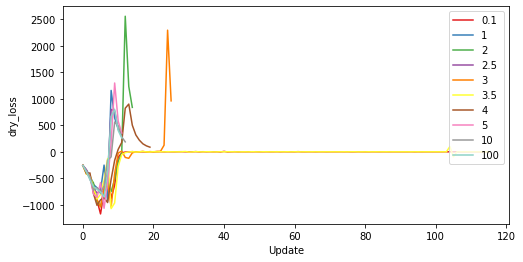

In [49]:
plot_sensitivity(*rewards_list,config=config,label_list=beta_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",beta_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

In [46]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 4
config["loss_name"]="adaptative_KL_loss"
print("-----------------"+config["loss_name"]+"-----------------")
beta_list = [1e-1,1,2,2.5,3,3.5,4,5,10,100]
for beta in beta_list:
    config['beta_KL'] = beta
    print('------------beta=',beta)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------adaptative_KL_loss-----------------
------------beta= 0.1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 0.1, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  adaptative_KL_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std

Episode 800/1000: Mean rewards: 74.8, Std: 30.56
Episode 825/1000: Mean rewards: 66.74, Std: 27.14
Episode 850/1000: Mean rewards: 68.22, Std: 25.29
Episode 875/1000: Mean rewards: 64.4, Std: 21.83
Episode 900/1000: Mean rewards: 48.32, Std: 12.69
Episode 925/1000: Mean rewards: 51.94, Std: 15.18
Episode 950/1000: Mean rewards: 49.9, Std: 17.36
Episode 975/1000: Mean rewards: 46.24, Std: 12.37
Episode 999/1000: Mean rewards: 48.76, Std: 12.3
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:57.722155
------------beta= 2.5
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 2.5, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': 

Episode 575/1000: Mean rewards: 86.4, Std: 28.17
Episode 600/1000: Mean rewards: 88.12, Std: 32.35
Episode 625/1000: Mean rewards: 80.18, Std: 28.41
Episode 650/1000: Mean rewards: 79.1, Std: 28.34
Episode 675/1000: Mean rewards: 65.34, Std: 24.03
Episode 700/1000: Mean rewards: 58.88, Std: 20.39
Episode 725/1000: Mean rewards: 52.3, Std: 16.98
Episode 750/1000: Mean rewards: 52.6, Std: 21.29
Episode 775/1000: Mean rewards: 57.3, Std: 21.33
Episode 800/1000: Mean rewards: 55.3, Std: 21.98
Episode 825/1000: Mean rewards: 50.92, Std: 18.99
Episode 850/1000: Mean rewards: 64.86, Std: 40.88
Episode 875/1000: Mean rewards: 51.12, Std: 15.62
Episode 900/1000: Mean rewards: 43.14, Std: 12.12
Episode 925/1000: Mean rewards: 43.78, Std: 11.0
Episode 950/1000: Mean rewards: 38.84, Std: 10.69
Episode 975/1000: Mean rewards: 42.22, Std: 11.29
Episode 999/1000: Mean rewards: 46.54, Std: 13.37
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:37.900167
-

Episode 350/1000: Mean rewards: 52.76, Std: 23.26
Episode 375/1000: Mean rewards: 59.64, Std: 29.26
Episode 400/1000: Mean rewards: 63.3, Std: 29.19
Episode 425/1000: Mean rewards: 72.1, Std: 24.12
Episode 450/1000: Mean rewards: 72.94, Std: 33.36
Episode 475/1000: Mean rewards: 67.86, Std: 24.94
Episode 500/1000: Mean rewards: 80.28, Std: 23.23
Episode 525/1000: Mean rewards: 79.36, Std: 24.98
Episode 550/1000: Mean rewards: 69.82, Std: 21.28
Episode 575/1000: Mean rewards: 75.5, Std: 27.63
Episode 600/1000: Mean rewards: 82.9, Std: 34.3
Episode 625/1000: Mean rewards: 79.9, Std: 26.53
Episode 650/1000: Mean rewards: 79.24, Std: 24.55
Episode 675/1000: Mean rewards: 64.22, Std: 29.96
Episode 700/1000: Mean rewards: 74.14, Std: 27.67
Episode 725/1000: Mean rewards: 75.54, Std: 28.85
Episode 750/1000: Mean rewards: 68.72, Std: 37.34
Episode 775/1000: Mean rewards: 72.04, Std: 28.82
Episode 800/1000: Mean rewards: 66.66, Std: 30.05
Episode 825/1000: Mean rewards: 63.82, Std: 30.81
Episod

Sensitivity list :  [0.1, 1, 2, 2.5, 3, 3.5, 4, 5, 10, 100]
Pickle name :  1589146685
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.8, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


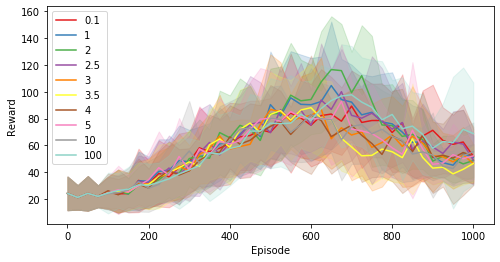

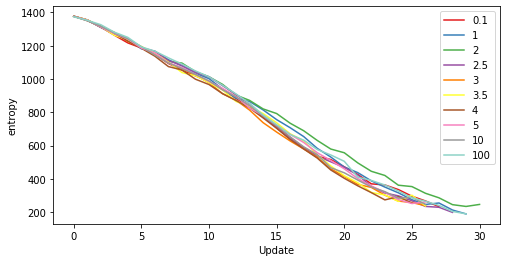

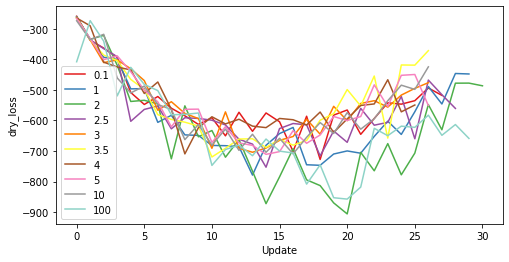

In [47]:
plot_sensitivity(*rewards_list,config=config,label_list=beta_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",beta_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

## Sensitivity to random seed

In [68]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 4
config["loss_name"]="clipped_loss"
print("-----------------"+config["loss_name"]+"-----------------")
seed_list = [1,2,3]
for seed in seed_list:
    config['seed'] = seed
    print('------------seed=',seed)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
------------seed= 1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std: 8.04
Episode 100/1

Episode 800/1000: Mean rewards: 249.82, Std: 109.06
Episode 825/1000: Mean rewards: 231.96, Std: 117.37
Episode 850/1000: Mean rewards: 302.62, Std: 102.68
Episode 875/1000: Mean rewards: 264.06, Std: 115.24
Episode 900/1000: Mean rewards: 283.1, Std: 81.39
Episode 925/1000: Mean rewards: 492.84, Std: 37.62
Episode 950/1000: Mean rewards: 487.86, Std: 36.99
Episode 975/1000: Mean rewards: 481.72, Std: 40.26
Episode 999/1000: Mean rewards: 484.3, Std: 38.75
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:03:21.939568


Sensitivity list :  [1, 2, 3]
Pickle name :  1589203469
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 3, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


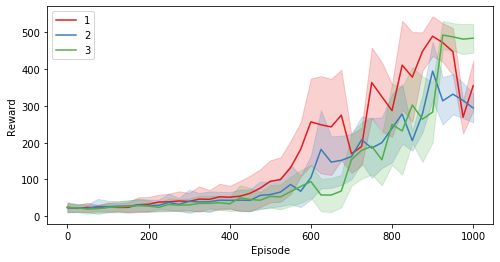

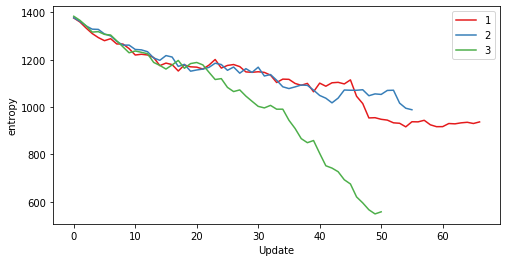

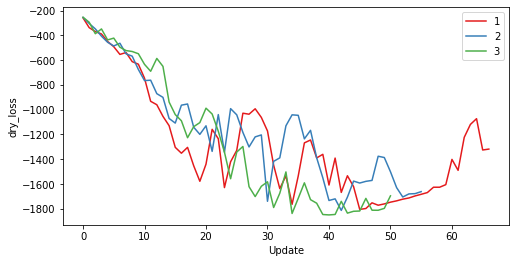

In [70]:
plot_sensitivity(*rewards_list,config=config,label_list=seed_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=seed_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=seed_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",seed_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

In [71]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 4
config["loss_name"]="adaptative_KL_loss"
print("-----------------"+config["loss_name"]+"-----------------")
seed_list = [1,2,3]
for seed in seed_list:
    config['seed'] = seed
    print('------------seed=',seed)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------adaptative_KL_loss-----------------
------------seed= 1
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  adaptative_KL_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std: 

Episode 800/1000: Mean rewards: 71.14, Std: 26.03
Episode 825/1000: Mean rewards: 80.0, Std: 34.77
Episode 850/1000: Mean rewards: 80.22, Std: 22.42
Episode 875/1000: Mean rewards: 62.24, Std: 22.13
Episode 900/1000: Mean rewards: 75.72, Std: 23.74
Episode 925/1000: Mean rewards: 67.32, Std: 28.61
Episode 950/1000: Mean rewards: 68.9, Std: 37.36
Episode 975/1000: Mean rewards: 64.58, Std: 20.08
Episode 999/1000: Mean rewards: 55.28, Std: 24.64
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:43.723815


Sensitivity list :  [1, 2, 3]
Pickle name :  1589203839
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.1, 'd_targ': 0.01, 'beta_KL': 100, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 100, 'loss_name': 'adaptative_KL_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 3, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


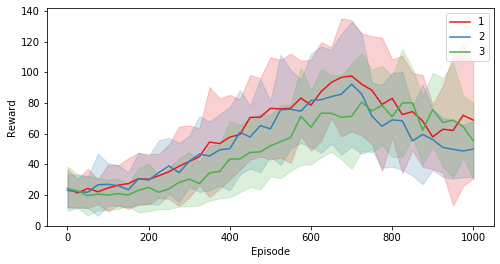

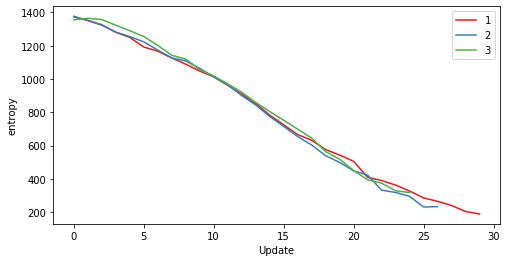

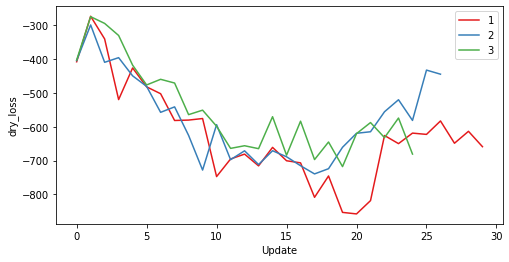

In [72]:
plot_sensitivity(*rewards_list,config=config,label_list=seed_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=seed_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=seed_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",seed_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

In [74]:
#TODO

reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["epochs"] = 4
config["loss_name"]="A2C_loss"
print("-----------------"+config["loss_name"]+"-----------------")
seed_list = [1,2,3]
for seed in seed_list:
    config['seed'] = seed
    print('------------seed=',seed)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

In [ ]:
#TODO
plot_sensitivity(*rewards_list,config=config,label_list=seed_list,var=["Episode","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=seed_list,var=["Update","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=seed_list,var=["Update","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",seed_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))